**Paper study developed by Henry Chacon as part of the survey review of Backdoor attacks including on my dissertation at UTSA.**

Contact information: henry.chacon@utsa.edu, henrychacon@gmail.com

# *Paper title:* Universal Litmus Patterns - Revealing Backdoor Attacks in CNNs

Authors: Kolouri et al. 
CVPR 2020. [Paper Link](https://openaccess.thecvf.com/content_CVPR_2020/html/Kolouri_Universal_Litmus_Patterns_Revealing_Backdoor_Attacks_in_CNNs_CVPR_2020_paper.html)

### Abstract

The unprecedented success of deep neural networks in many applications has made these networks a prime target for adversarial exploitation. In this paper, we introduce a benchmark technique for detecting backdoor attacks (aka Trojan attacks) on deep convolutional neural networks (CNNs). We introduce the concept of Universal Litmus Patterns (ULPs), which enable one to reveal backdoor attacks by feeding these universal patterns to the network and analyzing the output (i.e., classifying the network as `clean' or `corrupted'). This detection is fast because it requires only a few forward passes through a CNN. We demonstrate the effectiveness of ULPs for detecting backdoor attacks on thousands of networks with different architectures trained on four benchmark datasets, namely the German Traffic Sign Recognition Benchmark (GTSRB), MNIST, CIFAR10, and Tiny-ImageNet.

## Paper's main idea:
Creating a binary classifier to determine if a CNN model was trained with 20 backdoor attack patterns considered by the authors. The linear classifier they created receives as input an image that it is also optimized during the classifier training process. It means, the ULP (universal litmus pattern) is not any random image.

## Model definition:
The process receives as input a set of $N$ models $f_n$ labeled as clean or poisoned by $c_n \in \lbrace 0, 1 \rbrace$, represented by $\lbrace (f_n, cn)  \rbrace_{n=1}^N$. Then, a unique universal pattern $Z$ in the same domain as the input $X$, or $Z \in X$ will be trained to reveal if a model is either clean or backdoor. Author's classifier main idea can be expressed by the equation:
$$h(z) = f(z)  \times \mathbf{W}_{[\#classes \times 2]} + \mathbf{b}_{[1 \times 2 ]}, \qquad h(z) \in \{0, 1\}$$

Therefore, the list of parameters to trained during the process are: $z, \mathbf{W}, \mathbf{b}$, considering $h(z|\mathbf{W}, \mathbf{b})$. The optimization function defined by authors is:
$$\min_{z, h}  \sum_{n=1}^N \mathcal{L} \left[   h(g(f_n(z))), c_n   \right] +\lambda R(z)  $$

In this case, the _cross entropy_ loss function $\mathcal{L}()$ is used to compare the model's output based on the universal pattern, and the pooling operator $g()$. Finally, a regularization factor $\lambda$ is used in conjunction with $R()$ to limit the size of the universal pattern $z$. In case there is more than one universal pattern to be trained, please see the paper with the modifications in the above equation.

## Algorithm explanation:

The main process can be devided in the following steps:
1. Generate a sample of clean and backdoor CNN models $f_n$ and label them as $C_n=0$ nad $C_n=1$ for clean and backdoor respectively. Authors trained 500 models for each case, using 400 for training the ULP and 100 from each group for testing. 
2. Train the ULP model's parameters: $\mathbf{W}$, $\mathbf{b}$ and the universal pattern $\lambda$ over 800 models $\lbrace (f_n, C_n)  \rbrace_{n=1}^N$. In the paper's experiments, authors tested the ULP results using 1, 5 and 10 $\lambda$'s values.

## Code implementation:

The original code can be found in the [link](https://github.com/UMBCvision/Universal-Litmus-Patterns). In the below description, the code explanation will be done based on the two main steps decribed above.

### Step 1: Models generation:

You can train new models by using the following code or use the pre-trained list of models created and shared by authors. The code to use those models is found below this section.

**Clean models:**

This section is not different than the training of a regular CNN. Therefore, no additional comments are provided here.

In [3]:
import numpy as np

from torch import optim
from tqdm import tqdm

import utils.model as model
import pickle
import time
import os
import sys
import logging
import torch
from torch.utils import data
import glob
import matplotlib.pyplot as plt
import random

#logging
logfile = "./log.txt"
if not os.path.exists(os.path.dirname(logfile)):
    os.makedirs(os.path.dirname(logfile))

logging.basicConfig(
level=logging.INFO,
format="%(asctime)s %(message)s",
handlers=[
    logging.FileHandler(logfile, "w"),
    logging.StreamHandler()
])

class CIFAR10(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, mode='train',data_path='./Data/CIFAR10/',augment=False):
        'Initialization'
        if mode in ['train','test','val']:
            dataset,labels=pickle.load(open(data_path+mode+'_heq.p','rb'))
        else:
            raise Exception('Wrong mode!')
        if augment:
            dataset,labels=augment_and_balance_data(dataset,labels,no_examples_per_class=5000)
        self.data=torch.from_numpy(dataset).type(torch.FloatTensor).permute(0,3,1,2).contiguous()
        self.labels=torch.from_numpy(labels).type(torch.LongTensor)

        unique_labels=torch.unique(self.labels).sort()[0]
        self.class_weights_=(self.labels.shape[0]/torch.stack([torch.sum(self.labels==l).type(torch.DoubleTensor) for l in unique_labels]))
        self.weights=self.class_weights_[self.labels]

    def __len__(self):
        'Denotes the total number of samples'
        return self.labels.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data with random augmentation'
        # Select sample
        return self.data[index,...], self.labels[index]
    
    
class StratifiedSampler(torch.utils.data.Sampler):
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            logging.info('Need scikit-learn for this functionality')
        import numpy as np

        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=0.5)
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return np.hstack([train_index, test_index])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [4]:
# Hyperparameters definition:

use_cuda=True
batchsize=64
init_num_filters=64
inter_fc_dim=384
nofclasses=10           #CIFAR10
nof_epochs=50


# ### Load data and generate a train and validation loader
dataset=CIFAR10(mode='train',augment=False)
sampler=StratifiedSampler(dataset.labels,batchsize)
# sampler = torch.utils.data.sampler.WeightedRandomSampler(dataset.weights, 10000)
validation=CIFAR10(mode='val', augment=False)
train_loader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,sampler = sampler)
val_loader=torch.utils.data.DataLoader(validation,batch_size=batchsize,shuffle=True)

**Note:** You don't need to train clean models from scratch. It is recommended to use pre-trained models provided by authors, so this section could be skipped.

In [ ]:
# ### Start training
trained_models_folder='./clean_models/trainval'
# trained_models_folder='./clean_models/test'
if not os.path.isdir(trained_models_folder):
    os.makedirs(trained_models_folder)

saveDirmeta = os.path.join(trained_models_folder, 'meta')
if not os.path.exists(saveDirmeta):
    os.makedirs(saveDirmeta)

crossentropy=torch.nn.CrossEntropyLoss()
val_temp=0
train_labels=dataset.labels.type(torch.LongTensor)
val_labels=validation.labels.type(torch.LongTensor)
partition = 1
# count=400
runs=0
accuracy_val=list()
while runs<100:
    count = partition*100+runs
    val_temp=0
    logging.info('Training model %d'%(count))
    cnn=model.CNN_classifier(init_num_filters=init_num_filters,
                         inter_fc_dim=inter_fc_dim,nofclasses=nofclasses,
                         nofchannels=3,use_stn=False)

    # Compute number of parameters
    s  = sum(np.prod(list(p.size())) for p in cnn.parameters())
    print ('Number of params: %d' % s)

    if use_cuda:
        device=torch.device('cuda')
        cnn.cuda()
    else:
        device=torch.device('cpu')

    optimizer = optim.Adam(params=cnn.parameters(),lr=1e-2)

    for epoch in tqdm(range(nof_epochs)):
        epoch_loss=list()
        for x, y in train_loader:
            x=x.to(device) # CPU or Cuda
            y=y.to(device) # CPU or Cuda
            yhat = cnn(x)# Classify the encoded parts with a Softmax classifier
            loss = crossentropy(yhat,y) # Classification loss
            optimizer.zero_grad()
            loss.backward() # Backward pass
            optimizer.step()# Take a step
            #Keep track of losses
            epoch_loss.append(loss.item())

        # Calculate validation accuracy
        acc=list()
        for x,y in val_loader:
            x=x.to(device) # CPU or Cuda
            y=y.to(device) # CPU or Cuda
            val_pred = torch.argmax(cnn(x),dim=1)# Classify the encoded parts with a Softmax classifier
            acc.append((1.*(val_pred==y)).sum().item()/float(val_pred.shape[0]))
        val_accuracy=np.asarray(acc).mean()
        # Save the best model on the validation set
        if val_accuracy>=val_temp:
            torch.save(cnn.state_dict(),trained_models_folder+'/clean_vggmod_CIFAR-10_%04d.pt'%count)
            val_temp=np.copy(val_accuracy)
#         logging.info('Validation accuracy= %f'%(100.*val_temp))
        # Print epoch status
    #     logging.info('epoch=%03d, loss Y=%f, validation=%f'%(epoch, np.asarray(epoch_loss).mean(),
#                                                             100*val_accuracy))
    if val_temp>.75:
        # Doesn't save models that are not trained well
        accuracy_val.append(val_temp)
        pickle.dump(accuracy_val,open(saveDirmeta + '/clean_validation_CIFAR-10_{:02}.pkl'.format(partition),'wb'))
        runs+=1

    logging.info('Validation accuracy=%f%%'%(val_temp*100))
    torch.cuda.empty_cache()

**Backdoor models:**

In order to produce backdoor models, authors consider the following set of backdoor triggers to poison input images:

<img src="ULP_Patterns.png" alt="drawing" width="300"/>

Attacked images can be generated using the python code `generate_poison.py` found in their GitHub folder. However, they also shared a set of attacked images to be located in the path `./Attacked_Data/trainval/*.pkl`. An example of one of those images is the following:

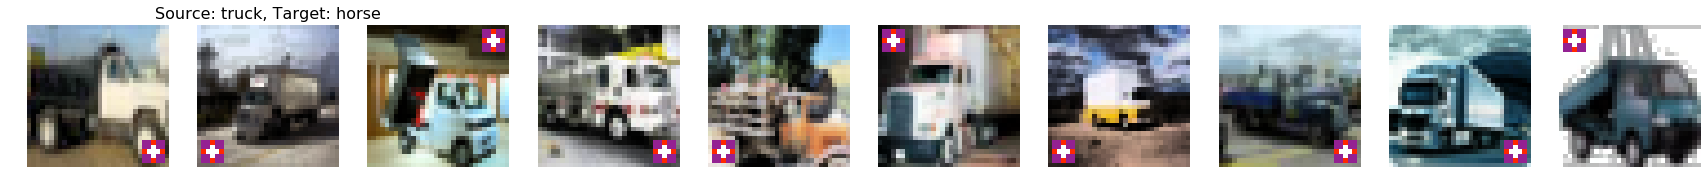

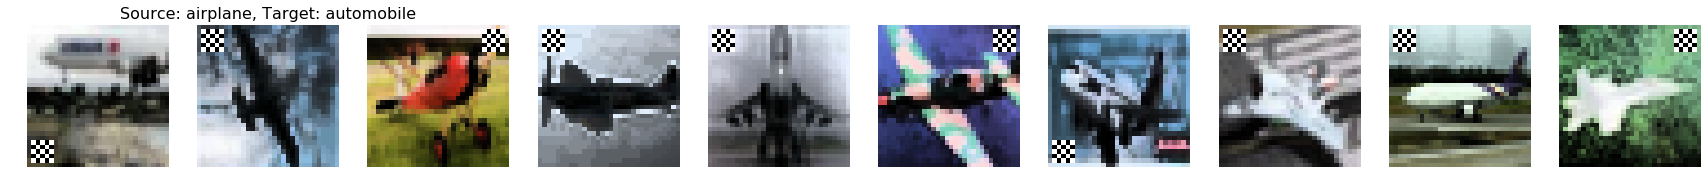

In [6]:
d=glob.glob('./Attacked_Data/trainval/*.pkl')
X_poisoned,y_poisoned,trigger,source,target=pickle.load(open(d[0],'rb'))

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_img = 10
fig = plt.figure(figsize=(30, 8))
for i, im_n in enumerate(random.sample(range(X_poisoned.shape[0]), num_img)):
    image = X_poisoned[im_n]
    plt.subplot(1, num_img, i+1)
    sample_image = np.squeeze(np.transpose(image, (0, 1, 2)))
    plt.imshow(image, cmap='gray' if (len(image.shape)==2) else None)
    plt.axis('off')
    if i==1:
        plt.title("Source: {}, Target: {}".format(cifar_labels[source], cifar_labels[target]), fontsize=16)
plt.show()

X_poisoned,y_poisoned,trigger,source,target=pickle.load(open(d[1],'rb'))
fig = plt.figure(figsize=(30, 8))
for i, im_n in enumerate(random.sample(range(X_poisoned.shape[1]), num_img)):
    image = X_poisoned[im_n]
    plt.subplot(1, num_img, i+1)
    sample_image = np.squeeze(np.transpose(image, (0, 1, 2)))
    plt.imshow(image, cmap='gray' if (len(image.shape)==2) else None)
    plt.axis('off')
    if i==1:
        plt.title("Source: {}, Target: {}".format(cifar_labels[source], cifar_labels[target]), fontsize=16)
plt.show()
    

Before backdoor models are trained, hyperparameters, and path location where they are saved are setting up. (Remember, the authors provided 500 backdoors and 500 clean models, so you can skip this section)

In [7]:
# ### Setting the hyper parameters
use_cuda=True
batchsize=64
init_num_filters=64
inter_fc_dim=384
nofclasses=10 #CIFAR10
nof_epochs=50

# ### Load clean data
dataset_clean=CIFAR10(mode='train',augment=False)
validation=CIFAR10(mode='val', augment=False)
val_loader=torch.utils.data.DataLoader(validation,batch_size=batchsize,shuffle=True)

# ### For a model for each attacked data (i.e. source target pairs that were saved in 01)
saveDir = './poisoned_models/trainval'
# saveDir = './poisoned_models/test'
saveDirmeta = os.path.join(saveDir, 'meta')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

if not os.path.exists(saveDirmeta):
    os.makedirs(saveDirmeta)

**Note:** You don't need to train backdoor models from scratch. It is recommended to use pre-trained models provided by authors, so this section could be skipped.

In [ ]:
class custom_Dataset(data.Dataset):
    def __init__(self,X,y):
        'Initialization'
        self.data=torch.from_numpy(X).type(torch.FloatTensor).permute(0,3,1,2).contiguous()
        self.labels=torch.from_numpy(y).type(torch.LongTensor)

    def __len__(self):
        'Denotes the total number of samples'
        return self.labels.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.data[index,...], self.labels[index]

def dataset_append(dataset: data.Dataset,X: np.array,y: np.array):
    new_dataset=custom_Dataset(X,y)
    new_dataset.data=torch.cat([new_dataset.data,dataset.data],0)
    new_dataset.labels=torch.cat([new_dataset.labels,dataset.labels],0)
    return new_dataset


d=glob.glob('./Attacked_Data/trainval/*.pkl')
# d=glob.glob('./Attacked_Data/test/*.pkl')
random.seed(10)
random.shuffle(d)
crossentropy=torch.nn.CrossEntropyLoss()
train_labels=dataset_clean.labels.type(torch.LongTensor)
val_labels=validation.labels.type(torch.LongTensor)
partition = 1
accuracy_val=list()
runs=0
poisoned_models = []
while runs<100:
#     count = partition*100+runs # This Jupyter Notebook is just for illustration, so only two attacked image set are considered here
    count = 0
    val_temp=0
    logging.info('Training model %d'%(count))
    X_poisoned,y_poisoned,trigger,source,target=pickle.load(open(d[count],'rb'))
    new_dataset=dataset_append(dataset_clean,X_poisoned,y_poisoned)


    X_poisoned_tensor = torch.from_numpy(X_poisoned).type(torch.FloatTensor).permute(0,3,1,2).contiguous()
    y_poisoned_tensor = torch.from_numpy(y_poisoned).type(torch.LongTensor)

    sampler=StratifiedSampler(new_dataset.labels,batchsize)
    train_loader=torch.utils.data.DataLoader(new_dataset,batch_size=batchsize,sampler=sampler)
    # train_loader=torch.utils.data.DataLoader(new_dataset,batch_size=batchsize, shuffle=True)  # without shuffling - ML class
    cnn=model.CNN_classifier(init_num_filters=init_num_filters,
                         inter_fc_dim=inter_fc_dim,nofclasses=nofclasses,
                         nofchannels=3,use_stn=False)

    # Compute number of parameters
    s  = sum(np.prod(list(p.size())) for p in cnn.parameters())
    print ('Number of params: %d' % s)

    if use_cuda:
        device=torch.device('cuda')
        cnn.cuda()
    else:
        device=torch.device('cpu')
    optimizer = optim.Adam(params=cnn.parameters(),lr=1e-2)
    for epoch in tqdm(range(nof_epochs)):
        cnn.train()
        epoch_loss=list()
        for x, y in train_loader:
            if x.shape[0]==1:
                break
            x=x.to(device) # CPU or Cuda
            y=y.to(device) # CPU or Cuda
            yhat = cnn(x)# Classify the encoded parts with a Softmax classifier
            loss = crossentropy(yhat,y) # Classification loss
            optimizer.zero_grad()
            loss.backward() # Backward pass
            optimizer.step()# Take a step
            #Keep track of losses
            epoch_loss.append(loss.item())


        with torch.no_grad():
            # Calculate validation accuracy
            acc=list()
            # acc_ut=list()
            cnn.eval()
            for x,y in val_loader:
                x=x.to(device) # CPU or Cuda
                y=y.to(device) # CPU or Cuda
                val_pred = torch.argmax(cnn(x),dim=1)# Classify the encoded parts with a Softmax classifier
                acc.append((1.*(val_pred==y)).sum().item()/float(val_pred.shape[0]))
            val_accuracy=np.asarray(acc).mean()
            # Save the best model on the validation set
            if val_accuracy>=val_temp:
                torch.save(cnn.state_dict(), saveDir+'/poisoned_vggmod_CIFAR-10_%04d.pt'%count)
                val_temp=np.copy(val_accuracy)

    # Filter based on validation accuracy and poison accuracy
    with torch.no_grad():
        pred=torch.argmax(cnn(X_poisoned_tensor.to(device)),1)
        poison_accuracy=float((1.*(pred==y_poisoned_tensor.to(device))).sum().item())/float(pred.shape[0])
    # poison_accuracy_ut=float((1.*(pred!=source)).sum().sitem())/float(pred.shape[0])
    logging.info("Max val acc:{:.3f} | Poison acc:{:.3f}".format(val_temp,poison_accuracy))

    if val_temp>.75 and poison_accuracy>.90:
        # Doesn't save models that are not trained well
        poisoned_models.append([saveDir+'/poisoned_vggmod_CIFAR-10_%04d.pt'%count,trigger,source,target,d[count]])
        pickle.dump(poisoned_models,open(saveDirmeta + '/poisoned_model_list_CIFAR-10_{:02}.pkl'.format(partition),'wb'))
        accuracy_val.append(val_temp)
        pickle.dump(accuracy_val,open(saveDirmeta + '/poisoned_validation_CIFAR-10_{:02}.pkl'.format(partition),'wb'))
        runs+=1

    logging.info('Validation accuracy=%f%%'%(val_temp*100))
    torch.cuda.empty_cache()

    # # save pkl for evaluation
    # pkl_save.append(['./Trained_models_poisoned/CIFAR10/trained%04d.pt'%n, trigger, source, target])
    # pickle.dump(pkl_save,open('poison_train_list_CIFAR10.pkl','wb'))

### Step 2: Training the ULP model:

To train the ULP, it is required to input a set of models and labels $\lbrace (f_n, C_n)  \rbrace_{n=1}^N$. The authors shared pre-trained models to train the ULP, both sets occupy around 9.2 GB, so a full analysis of the method is described here (based on the code) instead of producing the model.

Initially, hyperparameters and the CNN architecture of each individual model is defined. Then, the list of backdoor and clean models is provided. Notice that the first 400 models are used for training the ULP and the remaining 100 are considered for testing. The `N` parameter represents the number of universal patterns $z$ used to train the ULP. In this case, only one is suggested. Authors consider 1, 5, and 10. 

**Important**: To run this section you to saved clean and backdoor models in the folder `./poisoned_models/trainval/*.pt` and `./clean_models/trainval/*.pt`.

**Note:** You don't need to train the ULP model. We trained and shared models in our GitHub for N=1, 5, 10. So you can skip this section and go directly to **Step 3** and use our generated models.

In [ ]:
init_num_filters=64
inter_fc_dim=384
nofclasses=10 #CIFAR10
use_cuda=True

cnn=model.CNN_classifier(init_num_filters=init_num_filters,
                         inter_fc_dim=inter_fc_dim,nofclasses=nofclasses,
                         nofchannels=3,use_stn=False)
if use_cuda:
    device=torch.device('cuda')
    cnn.cuda()
else:
    device=torch.device('cpu')


N=1

# poisoned
poisoned_models_train = sorted(glob.glob('./poisoned_models/trainval/*.pt'))[:400]
poisoned_models_val = sorted(glob.glob('./poisoned_models/trainval/*.pt'))[400:]

# clean models
clean_models=glob.glob('./clean_models/trainval/*.pt')

# train - 400 clean 400 poisoned
models_train=clean_models[:400] + poisoned_models_train
labels_train=np.concatenate([np.zeros((len(clean_models[:400]),)),np.ones((len(poisoned_models_train),))])

# val - 100 clean 100 poisoned
models_val=clean_models[400:] + poisoned_models_val
labels_val=np.concatenate([np.zeros((len(clean_models[400:]),)),np.ones((len(poisoned_models_val),))])

print(len(models_train), len(models_val))
train_models,val_models,train_labels,val_labels=models_train,models_val,labels_train,labels_val

As it was mentioned at the beginning, only three parameters are trained during the process: the universal pattern or $z$ (defined in this case with the letter `X`), $\mathbf{W}$ and $\mathbf{b}$. The first two are randomly initialized, while the bias with zero.  

In [ ]:
X=torch.rand((N,3,32,32),requires_grad=True,device='cuda')
X.data*=255.
W=torch.randn((N*nofclasses,2),requires_grad=True,device='cuda')
b=torch.zeros((2,),requires_grad=True,device='cuda')

optimizerX = optim.SGD(params=[X],lr=1e+3)                 #1e+2
optimizerWb = optim.Adam(params=[W,b],lr=1e-3)          #1e-3

In [ ]:
cross_entropy=torch.nn.CrossEntropyLoss()

batchsize=50
REGULARIZATION=1e-6       #1e-6

Xgrad=list()
Wgrad=list()
bgrad=list()

max_val_accuracy=0
for epoch in range(1000):
    epoch_loss=list()
    randind=np.random.permutation(len(train_models))
    train_models=np.asarray(train_models)[randind]
    train_labels=train_labels[randind]
    for i,model in tqdm(enumerate(train_models)):
        cnn.load_state_dict(torch.load(model))    # CNN models loaded
        cnn.eval()
        label=np.array([train_labels[i]])
        y=torch.from_numpy(label).type(torch.LongTensor).to(device)
        
        # The linear classification function exhibited at the beginning is computed based on the current value of the universal pattern and (W, b)
        logit=torch.matmul(cnn(X.to(device)).view(1,-1),W)+b    

        # reg_loss corresponds to the regularization value: lambda *  R(z)
        reg_loss = REGULARIZATION * (torch.sum(torch.abs(X[:, :, :, :-1] - X[:, :, :, 1:])) +
                                     torch.sum(torch.abs(X[:, :, :-1, :] - X[:, :, 1:, :])))

        # Finally, the optimization function is computed based on the cross-entropy between the linear classifier and the model's label (0 for clean and 1 for backdoor)
        loss=cross_entropy(logit,y)+reg_loss

        optimizerWb.zero_grad()
        optimizerX.zero_grad()

        loss.backward()   
        if np.mod(i,batchsize)==0 and i!=0:
            Xgrad=torch.stack(Xgrad,0)
            X.grad.data=Xgrad.mean(0)
            optimizerX.step()

            X.data[X.data<0.]=0.
            X.data[X.data>255.]=255.

            Xgrad=list()
            Wgrad=list()
            bgrad=list()

        Xgrad.append(X.grad.data)
        optimizerWb.step()
        epoch_loss.append(loss.item())

    with torch.no_grad():
        pred=list()
        for i,model in enumerate(train_models):
            cnn.load_state_dict(torch.load(model))
            cnn.eval()
            label=np.array([train_labels[i]])
            logit=torch.matmul(cnn(X.to(device)).view(1,-1),W)+b
            pred.append(torch.argmax(logit,1))
        train_accuracy=(1*(np.asarray(pred)==train_labels.astype('uint'))).sum()/float(train_labels.shape[0])

        pred=list()
        for i,model in enumerate(val_models):
            cnn.load_state_dict(torch.load(model))
            cnn.eval()
            label=np.array([val_labels[i]])
            logit=torch.matmul(cnn(X.to(device)).view(1,-1),W)+b
            pred.append(torch.argmax(logit,1))
        val_accuracy=(1*(np.asarray(pred)==val_labels.astype('uint'))).sum()/float(val_labels.shape[0])

    if val_accuracy>=max_val_accuracy:
        pickle.dump([X.data,W.data,b.data],open('./results/ULP_vggmod_CIFAR-10_N{}.pkl'.format(N),'wb'))
        max_val_accuracy=np.copy(val_accuracy)

    logging.info('Epoch %03d Loss=%f, Train Acc=%f, Val Acc=%f'%(epoch,np.asarray(epoch_loss).mean(),train_accuracy*100.,val_accuracy*100.))
logging.info(max_val_accuracy)

## Testing the ULP classifier:

Three ULP models for $z=\lbrace 1, 5, 10  \rbrace$ were trained, and models are included in the repository in the folder `./results`. For testing the classifier, three clean and poisoned models are used:

In [8]:
print('List of models for testing the ULP:')
# poisoned
poisoned_models_test = sorted(glob.glob('./poisoned_models/test/*.pt'))
print('  - Backdoor models:', poisoned_models_test, '\n')

# clean models
clean_models=glob.glob('./clean_models/test/*.pt')
print('  - Clean models:', clean_models)

models_test=clean_models + poisoned_models_test
labels_test=np.concatenate([np.zeros((len(clean_models),)),np.ones((len(poisoned_models_test),))])

cnn=model.CNN_classifier(init_num_filters=init_num_filters,
                         inter_fc_dim=inter_fc_dim,nofclasses=nofclasses,
                         nofchannels=3,use_stn=False)
if use_cuda:
    device=torch.device('cuda')
    cnn.cuda()
else:
    device=torch.device('cpu')

List of models for testing the ULP:
  - Backdoor models: ['./poisoned_models/test/poisoned_vggmod_CIFAR-10_0000.pt', './poisoned_models/test/poisoned_vggmod_CIFAR-10_0001.pt', './poisoned_models/test/poisoned_vggmod_CIFAR-10_0002.pt'] 

  - Clean models: ['./clean_models/test/clean_vggmod_CIFAR-10_0002.pt', './clean_models/test/clean_vggmod_CIFAR-10_0000.pt', './clean_models/test/clean_vggmod_CIFAR-10_0001.pt']



++ Number of z = 1


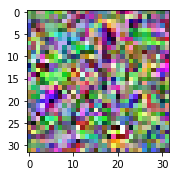

   Model: Clean, ULP detection: Clean 0.241, Backdoor 0.759
   Model: Clean, ULP detection: Clean 0.010, Backdoor 0.990
   Model: Clean, ULP detection: Clean 0.997, Backdoor 0.003
   Model: Backdoor, ULP detection: Clean 0.586, Backdoor 0.414
   Model: Backdoor, ULP detection: Clean 0.116, Backdoor 0.884
   Model: Backdoor, ULP detection: Clean 0.999, Backdoor 0.001

++ Number of z = 5


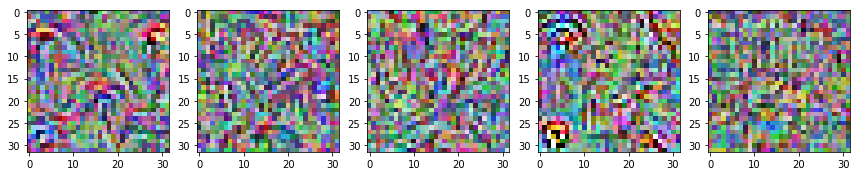

   Model: Clean, ULP detection: Clean 1.000, Backdoor 0.000
   Model: Clean, ULP detection: Clean 1.000, Backdoor 0.000
   Model: Clean, ULP detection: Clean 1.000, Backdoor 0.000
   Model: Backdoor, ULP detection: Clean 0.000, Backdoor 1.000
   Model: Backdoor, ULP detection: Clean 0.000, Backdoor 1.000
   Model: Backdoor, ULP detection: Clean 0.040, Backdoor 0.960

++ Number of z = 10


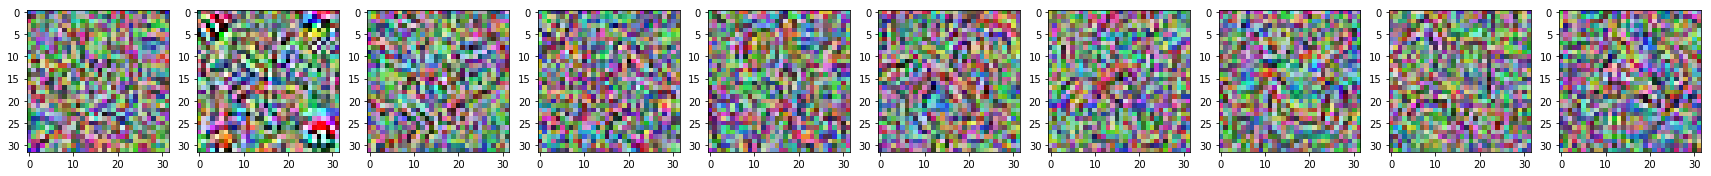

   Model: Clean, ULP detection: Clean 1.000, Backdoor 0.000
   Model: Clean, ULP detection: Clean 1.000, Backdoor 0.000
   Model: Clean, ULP detection: Clean 1.000, Backdoor 0.000
   Model: Backdoor, ULP detection: Clean 0.000, Backdoor 1.000
   Model: Backdoor, ULP detection: Clean 0.000, Backdoor 1.000
   Model: Backdoor, ULP detection: Clean 0.000, Backdoor 1.000


In [44]:
def getLogit(cnn,ulps,W,b,device):
    logit=torch.matmul(cnn(ulps.to(device)).view(1,-1),W)+b
    return logit

auc = list()
with torch.no_grad():
    for N in [1, 5, 10]:
        print('\n++ Number of universal patterns (z) = {}'.format(N))
        ulps,W,b=pickle.load(open('./results/ULP_vggmod_CIFAR-10_N{}.pkl'.format(N),'rb'))
        
        fig = plt.figure(figsize=(30, 8))
        for im_n in range(ulps.shape[0]):
            image = ulps[im_n].cpu().numpy()
            plt.subplot(1, 10, im_n+1)
            sample_image = np.squeeze(np.transpose(image, (1, 2, 0)))
            plt.imshow(np.round(sample_image).astype(int), cmap='gray' if (len(sample_image.shape)==2) else None)
        plt.show()
        
        features=list()
        probabilities=list()
        for i,model_ in enumerate(models_test):
            cnn.load_state_dict(torch.load(model_))
            cnn.eval()
            label=np.array([labels_test[i]])
            logit=getLogit(cnn,ulps,W,b,device)
            probs=torch.nn.Softmax(dim=1)(logit)
            features.append(logit.detach().cpu().numpy())
            probabilities.append(probs.detach().cpu().numpy())

            md = 'Backdoor' if label else "Clean"
            print('   Model: {}, ULP detection: Clean {:.3f}, Backdoor {:.3f}'.format(md, probs.squeeze().cpu().numpy()[0], probs.squeeze().cpu().numpy()[1]))


        features_np=np.stack(features).squeeze()
        probs_np=np.stack(probabilities).squeeze()